## Testing Accuracy of No-Bias Implementation

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

In [7]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    reg_grad = Ui * reg - (Yij - np.dot(Ui, Vj)) * Vj
    return eta * reg_grad

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    reg_grad = Vj * reg - (Yij - np.dot(Vj, Ui)) * Ui
    return eta * reg_grad

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    reg_term = reg * (np.linalg.norm(U, 'fro')**2 + np.linalg.norm(V, 'fro')**2) / 2
    
    least_square_sum = 0
    
    for (i, j, Yij) in Y:
        Ui = U[i - 1]
        Vj = V[j - 1]
        least_square_sum += (Yij - np.dot(Ui, Vj))**2
    
    least_square_sum /= 2
    
    return (reg_term + least_square_sum) / Y.shape[0]


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, size=(M, K))
    V = np.random.uniform(-0.5, 0.5, size=(N, K))
    initial_delta = 0
    old_loss = get_err(U, V, Y, reg)
    
    for epoch in range(max_epochs):
        
        indices = np.random.permutation(len(Y))
        
        for index in indices:
            (i, j, Yij) = Y[index]
            Ui = U[i - 1]
            Vj = V[j - 1]
            new_Ui = Ui - grad_U(Ui, Yij, Vj, reg, eta)
            new_Vj = Vj - grad_V(Vj, Yij, Ui, reg, eta)
            U[i - 1] = new_Ui
            V[j - 1] = new_Vj
        
        new_loss = get_err(U, V, Y, reg)
            
        if epoch == 0:
            initial_delta = new_loss - old_loss
        else:
            delta = new_loss - old_loss
            if abs(delta / initial_delta) <= eps:
                break
        
        old_loss = new_loss
        
    err = get_err(U, V, Y)
    return (U, V, err)

In [8]:
Y_train = np.loadtxt('./data/train_parsed.txt').astype(int)
Y_test = np.loadtxt('./data/test_parsed.txt').astype(int)

# data is 1 indexed.

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

reg = 0.1
eta = 0.03 # learning rate
K = 20

# Use to compute Ein and Eout
U,V, err = train_model(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err(U, V, Y_test)
print(E_in, E_out)


Factorizing with  943  users,  1664  movies.
0.3025475870443683 0.44954004994286934


## Training on Full Dataset

In [12]:
Y = np.loadtxt('./data/data_parsed.txt').astype(int)

# data is 1 indexed.

M = max(Y[:,0]).astype(int) # users
N = max(Y[:,1]).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

reg = 0.1
eta = 0.03 # learning rate
K = 20

# Use to compute Ein and Eout
U, V, err = train_model(M, N, K, eta, reg, Y)

Factorizing with  943  users,  1664  movies.


In [13]:
A, Sigma, Bt = svd(V.transpose())
V_tilde = np.matmul(A[:,:2].transpose(), V.transpose())
U_tilde = np.matmul(A[:,:2].transpose(), U.transpose())
V_x = V_tilde[0]
V_y = V_tilde[1]
U_x = U_tilde[0]
U_y = U_tilde[1]

## Visualizations

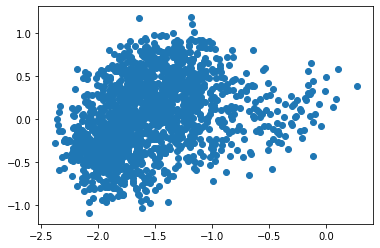

In [14]:
plt.scatter(V_x, V_y)

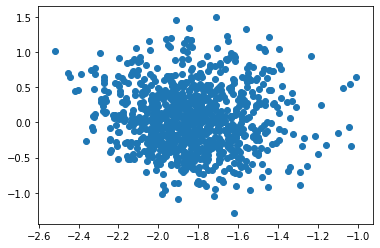

In [15]:
plt.scatter(U_x, U_y)